In [1]:
import numpy as np
import pandas as pd
from PyEMD import EMD, Visualisation
import scipy
import math
import scipy.io
import scipy.linalg

import sklearn.metrics
import sklearn.neighbors
from sklearn import metrics
from sklearn import svm

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import ipdb

# Utils

In [15]:
def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )


def sliding_window(T, T_org, seq_len, label_seq_len):

    # seq_len is equal to window_size
    # T (np.array) has dim: population, seq_len (window length)
    TT = T.reshape(-1, 1)
    K = TT.shape[0] - seq_len - label_seq_len + 1  # Li, et al., 2021, TRJ part C, pp. 8
    
    TT_org = T_org.reshape(-1, 1)

    # TT has dim: n, 1
    # assemble the data into 2D
    x_set = np.vstack(TT[i : K+i, 0] for i in range(seq_len)).T
    y_set = np.vstack(TT_org[i+seq_len : K+seq_len+i, 0] for i in range(label_seq_len)).T
    
    assert x_set.shape[0] == y_set.shape[0]

    # return size: n_samp, seq_len
    return x_set, y_set

In [20]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,6,6,1,10,1,64,3,3


In [16]:
X, Y = sliding_window(src_domain_emd, src_domain_emd, 10, 1)

C:\Users\10169\.conda\envs\bda_traff\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()
C:\Users\10169\.conda\envs\bda_traff\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [17]:
src_domain_emd.shape

(384,)

In [18]:
X.shape

(374, 10)

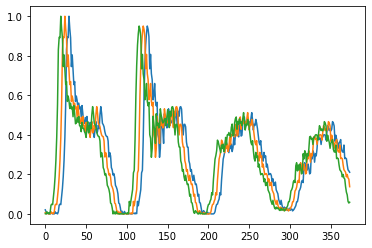

In [20]:
plt.plot(X[:, 0])
plt.plot(X[:, 5])
plt.plot(Y)

# 1. BDA Part
## 1.a. Define BDA methodology

In [3]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


def proxy_a_distance(source_X, target_X):
    """
    Compute the Proxy-A-Distance of a source/target representation
    """
    nb_source = np.shape(source_X)[0]
    nb_target = np.shape(target_X)[0]

    train_X = np.vstack((source_X, target_X))
    train_Y = np.hstack((np.zeros(nb_source, dtype=int),
                         np.ones(nb_target, dtype=int)))

    clf = svm.LinearSVC(random_state=0)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(train_X)
    error = metrics.mean_absolute_error(train_Y, y_pred)
    dist = 2 * (1 - 2 * error)
    return dist


def estimate_mu(_X1, _Y1, _X2, _Y2):
    adist_m = proxy_a_distance(_X1, _X2)
    C = len(np.unique(_Y1))
    epsilon = 1e-3
    list_adist_c = []
    for i in range(1, C + 1):
        ind_i, ind_j = np.where(_Y1 == i), np.where(_Y2 == i)
        Xsi = _X1[ind_i[0], :]
        Xtj = _X2[ind_j[0], :]
        adist_i = proxy_a_distance(Xsi, Xtj)
        list_adist_c.append(adist_i)
    adist_c = sum(list_adist_c) / C
    mu = adist_c / (adist_c + adist_m)
    if mu > 1:
        mu = 1
    if mu < epsilon:
        mu = 0
    return mu

In [4]:
class BDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, mu=0.5, gamma=1, T=10, mode='BDA', estimate_mu=False):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param mu: mu. Default is -1, if not specificied, it calculates using A-distance
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        :param mode: 'BDA' | 'WBDA'
        :param estimate_mu: True | False, if you want to automatically estimate mu instead of manally set it
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.mu = mu
        self.gamma = gamma
        self.T = T
        self.mode = mode
        self.estimate_mu = estimate_mu

    def fit(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))  # X.shape: [n_feature, ns+nt]
        X /= np.linalg.norm(X, axis=0)  # why it's axis=0?
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = len(np.unique(Ys))
        H = np.eye(n) - 1 / n * np.ones((n, n))
        mu = self.mu
        M = 0
        Y_tar_pseudo = None
        Xs_new = None
        for t in range(self.T):
            N = 0
            M0 = e * e.T * C
            if Y_tar_pseudo is not None and len(Y_tar_pseudo) == nt:
                for c in range(1, C + 1):
                    e = np.zeros((n, 1))
                    Ns = len(Ys[np.where(Ys == c)])
                    Nt = len(Y_tar_pseudo[np.where(Y_tar_pseudo == c)])

                    if self.mode == 'WBDA':
                        Ps = Ns / len(Ys)
                        Pt = Nt / len(Y_tar_pseudo)
                        alpha = Pt / Ps
                        mu = 1
                    else:
                        alpha = 1

                    tt = Ys == c
                    e[np.where(tt == True)] = 1 / Ns
                    yy = Y_tar_pseudo == c
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    e[tuple(inds)] = -alpha / Nt
                    e[np.isinf(e)] = 0  # ？
                    N = N + np.dot(e, e.T)

            # In BDA, mu can be set or automatically estimated using A-distance
            # In WBDA, we find that setting mu=1 is enough
            if self.estimate_mu and self.mode == 'BDA':
                if Xs_new is not None:
                    mu = estimate_mu(Xs_new, Ys, Xt_new, Y_tar_pseudo)
                else:
                    mu = 0
            M = (1 - mu) * M0 + mu * N
            M /= np.linalg.norm(M, 'fro')
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot(
                [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z /= np.linalg.norm(Z, axis=0)  # why it's axis=0?
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
            
            '''
            clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
            clf.fit(Xs_new, Ys.ravel())
            Y_tar_pseudo = clf.predict(Xt_new)
            acc = sklearn.metrics.accuracy_score(Yt, Y_tar_pseudo)
            list_acc.append(acc)
            print('{} iteration [{}/{}]: Acc: {:.4f}'.format(self.mode, t + 1, self.T, acc))
            '''
        return Xs_new, Xt_new, A  #, acc, Y_tar_pseudo, list_acc

## 1.b. Load Data

In [5]:
weekdays = np.array([np.arange(2+7*i,7+7*i,1) for i in range(4)]).flatten()
weekends = np.array([np.arange(7+7*i,9+7*i,1) for i in range(3)]).flatten()[:-1]

src_domain = np.array(pd.read_csv('../TCA_traffic/data/siteM4_2168B_20210101_20210131.csv'))[np.array([5,6,7,8]), :]
data_target = np.array(pd.read_csv('../TCA_traffic/data/siteM4_2188B_20210101_20210131.csv'))[20:25, :]

date_choosen = 10
num_test_day = 4
#tar_domain = data_target[weekdays[date_choosen:date_choosen+1 + num_test_day], :].reshape(-1, 96)
tar_domain = data_target.copy()
tgt_validation = tar_domain[1:num_test_day+1, :]

src_domain_emd = normalize(src_domain.flatten())
tar_domain_emd = normalize(tar_domain.flatten())

## 1.c. Extract features using EMD

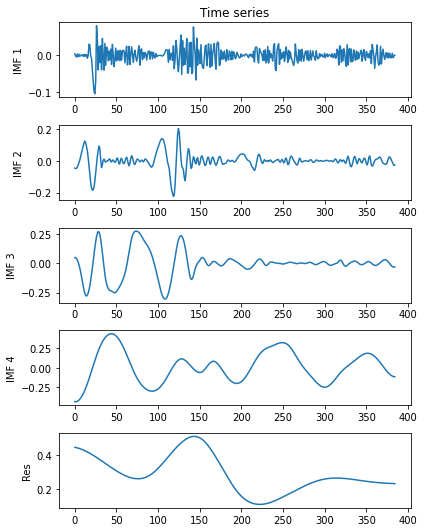

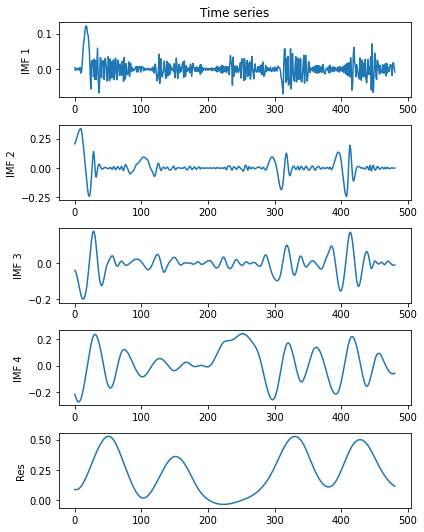

In [7]:
max_imf = 4

emd = EMD()
emd.emd(src_domain_emd, max_imf=max_imf)
imfs_src, res_src = emd.get_imfs_and_residue()
vis = Visualisation()
t_src = np.linspace(0, src_domain_emd.shape[0], src_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_src, residue=res_src, t=t_src, include_residue=True)
vis.show()

emd = EMD()
emd.emd(tar_domain_emd, max_imf=max_imf)
imfs_tar, res_tar = emd.get_imfs_and_residue()
vis = Visualisation()
t_tar = np.linspace(0, tar_domain_emd.shape[0], tar_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_tar, residue=res_tar, t=t_tar, include_residue=True)
vis.show()

Xs = np.concatenate([src_domain_emd.reshape(1, -1), imfs_src, res_src.reshape(1, -1)])
Xt = np.concatenate([tar_domain_emd.reshape(1, -1), imfs_tar, res_tar.reshape(1, -1)])
Xt_valid = Xt.copy()[:, 96:96*(num_test_day+1)]

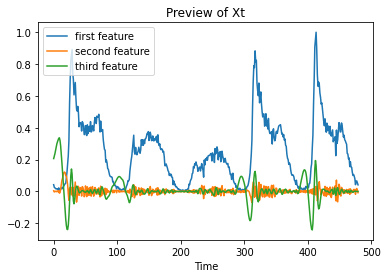

In [8]:
plt.plot(Xt[0, :], label='first feature')
plt.plot(Xt[1, :], label='second feature')
plt.plot(Xt[2, :], label='third feature')
plt.title('Preview of Xt')
plt.xlabel('Time')
plt.legend()
plt.show()

## 1.d. Hyperparameters

In [9]:
inp_dim = Xs.shape[0]
label_dim = Xs.shape[0]
label_seq_len = 1
# batch_size = full batch
seq_len = 10
reduced_dim = 1
hid_dim = 64
layers = 3
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

In [10]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,6,6,1,10,1,64,3,3


## 1.e. Apply BDA and get $Xs_{new}$, $Xt_{new}$ 

In [11]:
inp_dim -= reduced_dim
label_dim -= reduced_dim

In [18]:
Xs.shape

(384, 6)

In [17]:
bda = BDA(kernel_type='linear', dim=inp_dim, lamb=lamb, mu=0.5, gamma=1)
Xs, Xt = Xs.T, Xt.T
Xs_new, Xt_new, A = bda.fit(Xs, Xt)  # input shape: ns, n_feature
Xs_new, Xt_new = Xs_new.T, Xt_new.T
Xt_valid_new = Xt_new.copy()[:, 96:96*(num_test_day+1)]
Xt_new = Xt_new.copy()[:, :int(96)]

print(Xs_new.shape)
print(Xt_new.shape)

np2csv(Xt_valid_new)
np2csv(Xt_new)

TypeError: fit() missing 2 required positional arguments: 'Xt' and 'Yt'

In [ ]:
domains = ['caltech.mat', 'amazon.mat', 'webcam.mat', 'dslr.mat']
i, j = 0, 1  # Caltech -> Amazon
src, tar = '../data/' + domains[i], '../data/' + domains[j]
src_domain, tar_domain = scipy.io.loadmat(src), scipy.io.loadmat(tar)
Xs, Ys, Xt, Yt = src_domain['feas'], src_domain['label'], tar_domain['feas'], tar_domain['label']
bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5,
          mode='BDA', gamma=1, estimate_mu=False)
acc, ypre, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)
print(acc)